In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import time
import os, sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime

root_dir = '/media/harish/SSD/DL_based_wind_profile_estimation'
sys.path.append(root_dir)
from libraries import *
from plotters import *

print('Last updated: ', datetime.now())

Last updated:  2024-04-16 17:13:45.655415


In [2]:
#xr.open_mfdataset('/Users/hbaki/surfdrive/Ongoing_research/CERRA_height_level/*.nc',combine='nested',concat_dim='Time')
ds = xr.open_dataset('CERRA_height_level/2000.nc')
ds.lat[0].values,ds.lon[0].values

(array(54.0143), array(6.58385))

In [3]:
M = ds.data.isel(time=0,obs=0).data
Z = ds.heightAboveGround.data
print('sample wind:',M,' and sample height: ',Z)

sample wind: [ 8.63973579  8.77258289  9.15604775  9.44329194  9.68862232  9.8606943
 10.11217974 10.33011622 10.72232818 11.30109832 11.86516703 11.48229358]  and sample height:  [ 10.  15.  30.  50.  75. 100. 150. 200. 250. 300. 400. 500.]


Estimated parameters: a = 0.11875477679444796, b = 0.0009438900165520672, c = -0.0010329328387333045


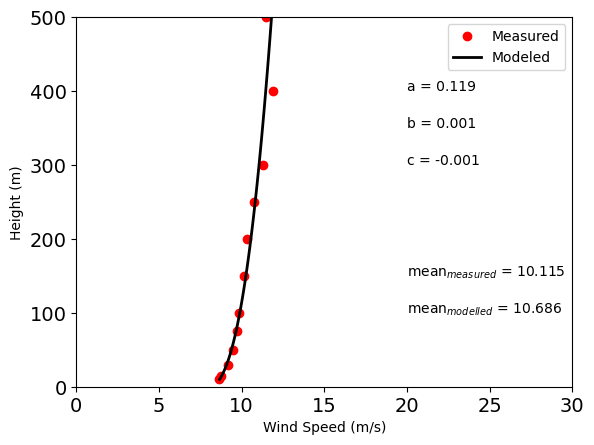

In [4]:
# Sample data
z = Z
u = M
# Extracting the estimated parameters
popt = Basu_Coeff(z,u)
a_est, b_est, c_est = popt
# Print estimated parameters
print(f"Estimated parameters: a = {a_est}, b = {b_est}, c = {c_est}")
# Plotting the data and the fit
z_fit = np.linspace(min(z), max(z), 100)
u_fit = Basu_WindProfile(z_fit, *popt)

# Plot and save the figure
fig, ax = plt.subplots()
ax.plot(M, Z, 'or', markerfacecolor='r')
ax.plot(u_fit, z_fit, '-k', linewidth=2)
ax.set(xlabel='Wind Speed (m/s)', ylabel='Height (m)')
ax.set_xlim([0, 30])
ax.set_ylim([0, 500])
ax.tick_params(labelsize=14)
ax.legend(['Measured', 'Modeled'])
plt.text(20, 400, f'a = {a_est:.3f}')
plt.text(20, 350, f'b = {b_est:.3f}')
plt.text(20, 300, f'c = {c_est:.3f}')
plt.text(20, 150, fr'mean$_{{measured}}$ = {M.mean():.3f}')
plt.text(20, 100, fr'mean$_{{modelled}}$ = {u_fit.mean():.3f}')
plt.savefig('Basu_fit_with_CERRA_data.png')

# Basu coefficients estimation for Heligoland observations

In [5]:
obs_levels = np.array([40, 50, 60, 70, 80, 90, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300, 320, 340, 360, 380, 400, 450, 500])
df_Obs = pd.read_csv('Heligoland_wind.csv',index_col=0,parse_dates=True)
# Resampling the data to hourly frequency, by averaging the values
df_Obs = df_Obs.resample('H').mean() #['Obs_wind_speed']['ws_50_m']

In [6]:
# find the index of completely empty rows
empty_rows = df_Obs.index[df_Obs.isnull().all(axis=1)]
# find the index of rows with at least one missing value
missing_rows = df_Obs.index[df_Obs.isnull().any(axis=1)]
# find the index of rows with no missing values
non_missing_rows = df_Obs.index[~df_Obs.isnull().any(axis=1)]
print('Number of empty rows: ', len(empty_rows),'\n', 
      'Number of rows with missing values: ', len(missing_rows), '\n',
      'Number of rows with no missing values: ', len(non_missing_rows))

print(f'Now, the Idea is to use the {len(non_missing_rows)} values in Tabnet training, validation and testing.')
n_train = round(0.7*len(non_missing_rows))
n_val = round(0.2*len(non_missing_rows))
n_test = len(non_missing_rows) - n_train - n_val
print(f'In which, {n_train} for training, {n_val} for validation and {n_test} for testing.')
print(f'Post training, the missing data of {len(missing_rows)} rows will be predicted using the trained model.\n' 
      'This step is synonymous to the TabNet testing, since some partial observations does exist for these rows.')
print(f'And the empty rows {len(empty_rows)} will be filled using the trained TabNet predictions.')


Number of empty rows:  475 
 Number of rows with missing values:  2202 
 Number of rows with no missing values:  7026
Now, the Idea is to use the 7026 values in Tabnet training, validation and testing.
In which, 4918 for training, 1405 for validation and 703 for testing.
Post training, the missing data of 2202 rows will be predicted using the trained model.
This step is synonymous to the TabNet testing, since some partial observations does exist for these rows.
And the empty rows 475 will be filled using the trained TabNet predictions.


In [7]:
M = df_Obs.loc['2017-05-17T21:00:00':'2017-05-17T21:00:00'].values[0]
Z = obs_levels
print('sample wind:',M,' and sample height: ',Z, normalize(Z))

sample wind: [13.63833333 14.75666667 14.98166667 14.94       15.00666667 15.12333333
 15.28333333 15.57666667 15.87666667 16.16666667 16.47333333 16.80666667
 17.09333333 17.36833333 17.62166667 17.885      18.08666667 18.305
 18.52       18.69666667 18.845      18.91666667 18.96166667 18.77833333]  and sample height:  [ 40  50  60  70  80  90 100 120 140 160 180 200 220 240 260 280 300 320
 340 360 380 400 450 500] [-1.         -0.95652174 -0.91304348 -0.86956522 -0.82608696 -0.7826087
 -0.73913043 -0.65217391 -0.56521739 -0.47826087 -0.39130435 -0.30434783
 -0.2173913  -0.13043478 -0.04347826  0.04347826  0.13043478  0.2173913
  0.30434783  0.39130435  0.47826087  0.56521739  0.7826087   1.        ]


Estimated parameters: a = 0.09521216447591116, b = -0.005470869381776388, c = -0.000252294341474067


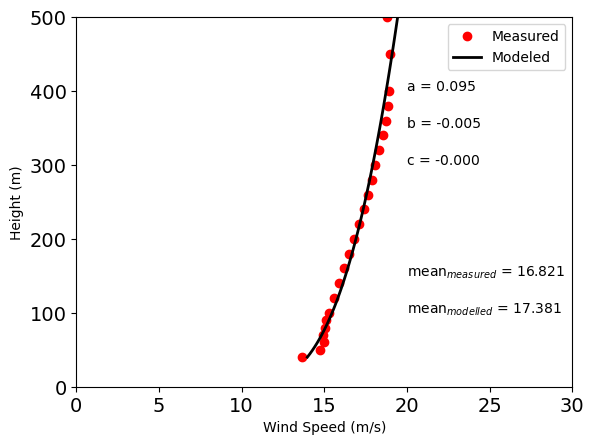

In [8]:
# Sample data
z = Z
u = M
# Perform curve fitting
popt = Basu_Coeff(z,u)
a_est, b_est, c_est = popt
# Print estimated parameters
print(f"Estimated parameters: a = {a_est}, b = {b_est}, c = {c_est}")
# Plotting the data and the fit
z_fit = np.linspace(min(z), max(z), 100)
u_fit = Basu_WindProfile(z_fit, *popt)

# Plot and save the figure
fig, ax = plt.subplots()
ax.plot(M, Z, 'or', markerfacecolor='r')
ax.plot(u_fit, z_fit, '-k', linewidth=2)
ax.set(xlabel='Wind Speed (m/s)', ylabel='Height (m)')
ax.set_xlim([0, 30])
ax.set_ylim([0, 500])
ax.tick_params(labelsize=14)
ax.legend(['Measured', 'Modeled'])
plt.text(20, 400, f'a = {a_est:.3f}')
plt.text(20, 350, f'b = {b_est:.3f}')
plt.text(20, 300, f'c = {c_est:.3f}')
plt.text(20, 150, fr'mean$_{{measured}}$ = {M.mean():.3f}')
plt.text(20, 100, fr'mean$_{{modelled}}$ = {u_fit.mean():.3f}')
plt.savefig('Basu_fit_with_Heligoland_data.png')

In [9]:
def compute_coefficients(Z, U):
    try:
        coefficients = Basu_Coeff(Z, U)
    except Exception as e:
        print(f"Error computing coefficients: {e}")
        coefficients = [np.nan, np.nan, np.nan]  # Set coefficients to NaN
    return coefficients

In [ ]:
# Number of observations, time steps, and height levels
n_time, n_height = df_Obs.loc[non_missing_rows].shape
# Initialize Coeff array
Coeff = np.zeros(( n_time, 3))
U = df_Obs.loc[non_missing_rows].values

stime = time.time()
for t in range(n_time):
    Coeff[t, :] = compute_coefficients(Z,U[t, :])
    print(t)
etime = time.time()

print(f'Time elapsed: {etime-stime}s')
coeff_da = xr.DataArray(Coeff, dims=['time', 'coeff'], coords={'time': non_missing_rows, 'coeff': np.arange(3)},name='data')
coeff_da.to_netcdf('Heligoland_Basu_Coefficnents.nc')

In [11]:
print(f'number of instances that Basu function failed to compute coefficients is: {np.isnan(coeff_da.data[:,2]).sum()}')

number of instances that Basu function failed to compute coefficients is: 42


In [35]:
times = coeff_da.time.values

ChSh_Coeff = xr.open_dataset('Heligoland_Chebyshev_Coefficnents.nc')
Z_CERRA = xr.open_dataset('CERRA_height_level/2000.nc').heightAboveGround.data
ChSh_Coeff_subset = ChSh_Coeff.sel(time=times, method='nearest').data.values

In [36]:
U.shape, ChSh_Coeff_subset.data.shape, coeff_da.data.shape

((7026, 24), (7026, 5), (7026, 3))

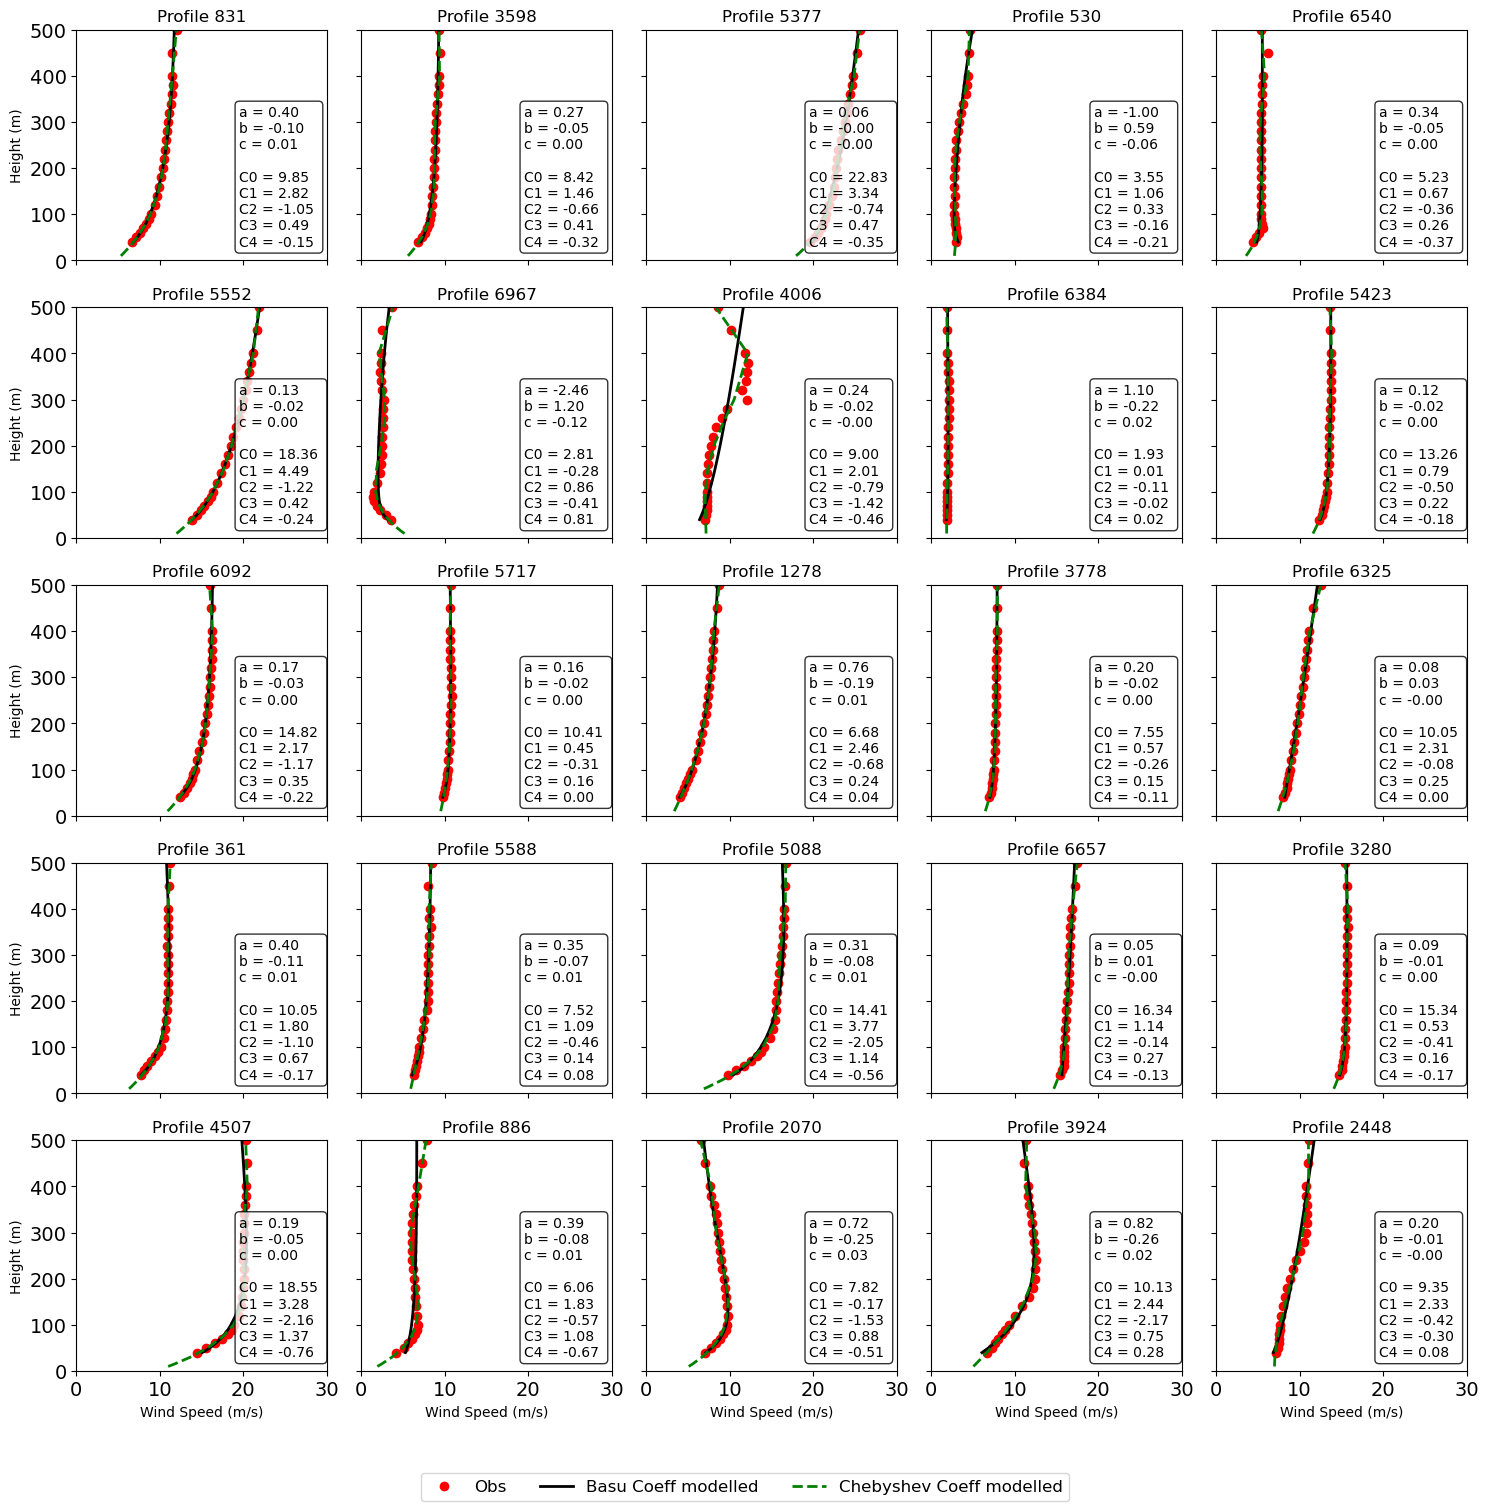

In [43]:
# Set a seed for reproducibility
np.random.seed(9)

# Select 25 random samples
random_indices = np.random.choice(len(coeff_da), size=25, replace=False)

# Create a 5x5 grid of subplots
fig, axs = plt.subplots(5, 5, figsize=(15, 15), sharex=True, sharey=True)

# Plot the selected samples
for i, ax in zip(random_indices, axs.flatten()):
    M = U[i, :]
    M_Basu = Basu_WindProfile(Z, coeff_da.data[i,0],coeff_da.data[i,1],coeff_da.data[i,2])
    M_Cheby = WindProfile(Z_CERRA, ChSh_Coeff_subset[i,:])
    ax.plot(M, Z, 'or', markerfacecolor='r',label='Obs')
    ax.plot(M_Basu, Z, '-k', linewidth=2,label='Basu Coeff modelled')
    ax.plot(M_Cheby, Z_CERRA, '--g', linewidth=2,label='Chebyshev Coeff modelled')

    ax.text(0.65, 0.05, f'a = {coeff_da.data[i,0]:.2f} \nb = {coeff_da.data[i,1]:.2f} \nc = {coeff_da.data[i,2]:.2f}\n\n'
            f'C0 = {ChSh_Coeff_subset[i,0]:.2f} \nC1 = {ChSh_Coeff_subset[i,1]:.2f}'
            f'\nC2 = {ChSh_Coeff_subset[i,2]:.2f} \nC3 = {ChSh_Coeff_subset[i,3]:.2f} \nC4 = {ChSh_Coeff_subset[i,4]:.2f}',
                      transform=ax.transAxes, verticalalignment='bottom', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    ax.set_xlim([0, 30])
    ax.set_ylim([0, 500])
    ax.tick_params(labelsize=14)
    ax.set_title(f'Profile {i}')

# Set common labels
for ax in axs.flat:
    ax.set(xlabel='Wind Speed (m/s)', ylabel='Height (m)')
    ax.label_outer()

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Extract legend from one of the subplots
handles, labels = ax.get_legend_handles_labels()
# Create a common legend below the figures
fig.legend(handles, labels, loc='lower center', ncol=len(labels), bbox_to_anchor=(0.5, -0.05),fontsize=12)

# Show the plot
plt.savefig('Basu_and_Chebshev_Coeff_fit_with_obs_data.pdf',dpi=300,bbox_inches='tight',pad_inches=0)